In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from cosmoblender import tools as tls
from cosmoblender import qest
from cosmoblender import biases

IMPORT ERROR: /Users/antonbaleatolizancos/Software/Quicklens-with-fixes/quicklens/mpi.py (No module named 'pypar'). Could not load pbs or pypar. MPI will not be used.
IMPORT ERROR: /Users/antonbaleatolizancos/Software/Quicklens-with-fixes/quicklens/shts/__init__.py (No module named 'fsht'). Try running 'python setup.py install' or 'python setup.py build_ext --inplace' from the quicklens directory.








Initialise experiment object

In [2]:
# Foreground cleaning? Only relevant if many frequencies are provided
MV_ILC_bool = True 
deproject_CIB = False
deproject_tSZ = False
fg_cleaning_dict = {'MV_ILC_bool':MV_ILC_bool, 'deproject_CIB':deproject_CIB, 'deproject_tSZ':deproject_tSZ}

In [3]:
SPT_properties = {'nlev_t': np.array([18.]),
                  'beam_size':np.array([1.]),
                  'freq_GHz': np.array([143.])}

# Initialise experiments with various different mass cuts
SPT_5e15 = qest.experiment(lmax = 3000, massCut_Mvir=5e15, **SPT_properties, **fg_cleaning_dict)

In [3]:
SO_properties = {'nlev_t': np.array([52., 27., 5.8, 6.3, 15., 37.]),
                 'beam_size':np.array([7.4, 5.1, 2.2, 1.4, 1.0, 0.9]),
                 'freq_GHz': np.array([27.3, 41.7, 93., 143., 225.,278.])}

# Initialise experiments with various different mass cuts
SO_5e15 = qest.experiment(lmax = 4000, massCut_Mvir=5e15, **SO_properties, **fg_cleaning_dict)

In [4]:
# Choose an experiment
experiment = SPT_5e15

One can later inspect the properties by doing

In [6]:
print(experiment)

Mass Cut: 5.00e+15  lmax: 4000  Beam FWHM: [7.4 5.1 2.2 1.4 1.  0.9] Noise (uK arcmin): [52.  27.   5.8  6.3 15.  37. ]  Freq (GHz): [ 27.3  41.7  93.  143.  225.  278. ]


Initialise halo model calculator

In [63]:
# You can specify a cosmological model -- in this case, match Websky
H0 = 68.
cosmoParams = {'As':2.08e-9,'ns':.965,'omch2':(0.31-0.049)*(H0/100.)**2,'ombh2':0.049*(H0/100.)**2,'tau':0.055,'H0':H0}

z_max = 3 #3
nZs = 20 #50
nMasses = 30  #30
Mmin = 1e8 #Keep this low -- the 2h term of the bispectrum bias can be sensitive to quite low-mass halos

# Set CIB halo model
cib_model='planck13'#'vierro'

# Initialise a halo model object for the calculation, using mostly default parameters
hm_calc = biases.hm_framework(cosmoParams=cosmoParams, m_min=Mmin, nZs=nZs, nMasses=nMasses, cib_model=cib_model, z_max=z_max)

Again, we can print out its properties

In [6]:
print(hm_calc)

M_min: 1.00e+12  M_max: 5.00e+16  n_Masses: 20
  z_min: 0.07  z_max: 3.00  n_zs: 20
  Mass function: sheth-torman  Mass definition: vir


# Calculate the biases

Run the main function for each of the mass cuts, and for either the tsz or cib calculation, using the FFTlog approach

We can also calculate the secondary bispectrum bias though this is considerably slower (takes around 40 minutes to calculate bias every 100 ells from m14 to 3000 with nz=30, nMasses=30) using a single core

Calculate and plot the biases

In [1]:
which_bias = 'mixed' # 'tsz' or 'cib' or 'mixed'

# Calculate secondary bispectrum bias? Note that this is a lot slower that the other implemented terms
get_secondary_bispec_bias = False

if which_bias=='tsz':
    hm_calc.get_tsz_auto_biases(experiment, get_secondary_bispec_bias=get_secondary_bispec_bias)
if which_bias=='cib':
    hm_calc.get_cib_auto_biases(experiment, get_secondary_bispec_bias=get_secondary_bispec_bias)
if which_bias=='mixed':
    hm_calc.get_mixed_auto_biases(experiment, get_secondary_bispec_bias=get_secondary_bispec_bias)

# Break down contributions into n-halo terms?
breakdown = False

NameError: name 'hm_calc' is not defined

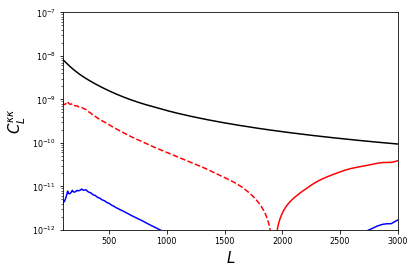

In [65]:
plt.figure()
title=''

scaling = experiment.biases['ells']**4 /4.
if get_secondary_bispec_bias:
    # TODO: a factor of 1/2 would make the 2ndary bispec agree better with expectations
    scaling_second_bispec_bias = experiment_2ndarybispec.biases['second_bispec_bias_ells']**4 /4.
    scaling_second_bispec_bias[:3] = np.nan

# Split into negative and positive parts for plotting convenience
prim_bispec_1h_pos, prim_bispec_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['1h'])
prim_bispec_2h_pos, prim_bispec_2h_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['2h'])
prim_bispec_tot_pos, prim_bispec_tot_neg = tls.split_positive_negative(experiment.biases[which_bias]['prim_bispec']['2h']+experiment.biases[which_bias]['prim_bispec']['1h'])

trispec_1h_pos, trispec_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['1h'])
trispec_2h_pos, trispec_2h_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['2h'])
trispec_tot_pos, trispec_tot_neg = tls.split_positive_negative(experiment.biases[which_bias]['trispec']['2h']+ experiment.biases[which_bias]['trispec']['1h'])

if get_secondary_bispec_bias:
    sec_bispec_1h_pos, sec_bispec_1h_neg = tls.split_positive_negative(experiment_2ndarybispec.biases[which_bias]['second_bispec']['1h'])
    #FIXME: for now, ony 1h term for secondary bispec bias
    sec_bispec_tot_pos, sec_bispec_tot_neg = tls.split_positive_negative ( 0 +experiment_2ndarybispec.biases[which_bias]['second_bispec']['1h'])


plt.plot(experiment.biases['ells'], scaling * trispec_tot_pos, color='b', label=r'{} trispec. bias, tot '.format(which_bias))
plt.plot(experiment.biases['ells'], scaling * trispec_tot_neg, color='b', ls='--')

if breakdown:
    title='_withbreakdown'
    plt.plot(experiment.biases['ells'], scaling * trispec_1h_pos, color='b', label=r'{} trispec. bias, 1h '.format(which_bias), ls=':')
    plt.plot(experiment.biases['ells'], scaling * trispec_1h_neg, color='b', ls=':')

    plt.plot(experiment.biases['ells'], scaling * trispec_2h_pos, color='b', label=r'{} trispec. bias, 2h '.format(which_bias), ls='-.')
    plt.plot(experiment.biases['ells'], scaling * trispec_2h_neg, color='b', ls='-.')

plt.plot(experiment.biases['ells'], scaling * prim_bispec_tot_pos, color='r',label=r'{} prim. bispec. bias, tot'.format(which_bias))
plt.plot(experiment.biases['ells'], scaling * prim_bispec_tot_neg, color='r', ls='--')

if breakdown:
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_1h_pos, color='r', label=r'{} prim. bispec. bias, 1h '.format(which_bias), ls=':')
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_1h_neg, color='r', ls=':')

    plt.plot(experiment.biases['ells'], scaling * prim_bispec_2h_pos, color='r', label=r'{} prim. bispec. bias, 2h '.format(which_bias), ls='-.')
    plt.plot(experiment.biases['ells'], scaling * prim_bispec_2h_neg, color='r', ls='-.')

if get_secondary_bispec_bias:
    plt.plot(experiment_2ndarybispec.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_tot_pos, color='orange',label=r'{} sec. bispec. bias, tot'.format(which_bias))
    plt.plot(experiment_2ndarybispec.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_tot_neg, color='orange', ls='--')

    if breakdown:
        plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_1h_pos, color='orange', label=r'{} sec. bispec. bias, 1h '.format(which_bias), ls=':')
        plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_1h_neg, color='orange', ls=':')

        #plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_2h_pos, color='gold', label=r'{} sec. bispec. bias, 2h '.format(which_bias), ls='-.')
        #plt.plot(experiment.biases['second_bispec_bias_ells'], scaling_second_bispec_bias * sec_bispec_2h_neg, color='gold', ls='-.')

plt.plot(experiment.cl_unl.ls, 0.05* experiment.cl_unl.ls**4 * experiment.cl_unl.clpp /4.,'k')
plt.yscale('log')
plt.ylabel(r'$C_L^{\kappa\kappa}$',fontsize=15)
plt.xlabel(r'$L$',fontsize=15)
plt.xlim([100,3000])
plt.ylim([1e-12,1e-7])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

We can save the dictionary of biases to file as

In [116]:
experiment.save_biases()

and later retrieve them as

In [117]:
dict_of_biases = qest.load_dict_of_biases()

Successfully loaded experiment object with properties:

{'ells': array([   0,    1,    2, ..., 2998, 2999, 3000]), 'second_bispec_bias_ells': {}, 'tsz': {'trispec': {'1h': array([0.00000000e+00+0.j, 2.16351424e-10+0.j, 2.16207040e-10+0.j, ...,
       3.68970128e-21+0.j, 3.69730715e-21+0.j, 3.70492088e-21+0.j]), '2h': array([0.00000000e+00+0.00000000e+00j, 1.89782161e-11+9.41773579e-25j,
       3.12650331e-11+1.55149367e-24j, ...,
       6.40463738e-26+8.35398018e-46j, 6.41283229e-26+8.36466933e-46j,
       6.42102506e-26+8.37535568e-46j])}, 'prim_bispec': {'1h': array([           nan           +nanj, 1.71718396e-10+4.26067043e-24j,
       5.72204467e-11+1.41975158e-24j, ...,
       2.18498039e-23+1.42500518e-43j, 2.18483004e-23+1.42490713e-43j,
       2.18467804e-23+1.42480799e-43j]), '2h': array([           nan           +nanj, 1.14259934e-09+2.83501321e-23j,
       6.32492210e-10+1.56933731e-23j, ...,
       5.55929058e-25+3.62567001e-45j, 5.55690311e-25+3.62411294e-45j,
       5.554

We can also use the standard Quicklens implementation of the QEs instead of FFTlog

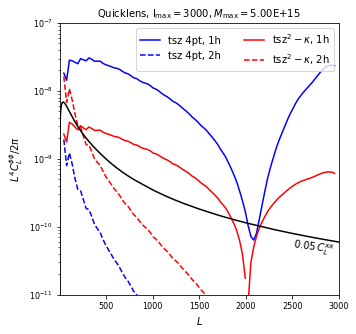

In [11]:
plt.figure(figsize=(5,5))
scaling = experiment.biases['ells']**4 /(2*np.pi)

flat_sky_correction = 1

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['1h']>0],flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['1h'])[experiment.biases[which_bias]['trispec']['1h']>0],color='b',label=r'{} 4pt, 1h '.format(which_bias))

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['2h']>0],flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['2h'])[experiment.biases[which_bias]['trispec']['2h']>0],color='b',label=r'{} 4pt, 2h '.format(which_bias),ls='--')
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['trispec']['2h']<0],-flat_sky_correction**2 *(scaling * experiment.biases[which_bias]['trispec']['2h'])[experiment.biases[which_bias]['trispec']['2h']<0],color='b',ls='--')

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['1h']>0],flat_sky_correction *(scaling *experiment.biases[which_bias]['prim_bispec']['1h'])[experiment.biases[which_bias]['prim_bispec']['1h']>0],color='r',label=r'{}$^2-\kappa$, 1h'.format(which_bias))
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['1h']<0],-flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['1h'])[experiment.biases[which_bias]['prim_bispec']['1h']<0],color='r')

plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['2h']>0],flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['2h'])[experiment.biases[which_bias]['prim_bispec']['2h']>0],color='r',label=r'{}$^2-\kappa$, 2h'.format(which_bias),ls='--')
plt.plot(experiment.biases['ells'][experiment.biases[which_bias]['prim_bispec']['2h']<0],-flat_sky_correction*(scaling *experiment.biases[which_bias]['prim_bispec']['2h'])[experiment.biases[which_bias]['prim_bispec']['2h']<0],color='r',ls='--')

plt.annotate(r'$0.05\,C_L^{\kappa \kappa}$', (2500,4e-11), rotation=-8)
plt.plot(experiment.cl_unl.ls, 0.05* experiment.cl_unl.ls**4 * experiment.cl_unl.clpp /(2*np.pi),'k')
plt.yscale('log')
plt.legend(fontsize=10, ncol=2)
plt.ylabel(r'$L^4 C_L^{\phi\phi}/ 2\pi$',fontsize=10)
plt.xlabel(r'$L$',fontsize=10)
plt.title(r'Quicklens, l$_{\mathrm{max}}=$'+str(lmax)+'$, M_{\mathrm{max}}=$'+'{:.2E}'.format(experiment.massCut), fontsize=10)
plt.xlim([2,3000])
plt.ylim([1e-11,1e-7])

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plt.savefig('../plots/tsz_bias_for_diff_mass_cuts/1D_reconstructions/biases_lmax{}_masscut{}.pdf'.format(lmax, '1e14'))


# Calculate biases to cross-correlations with galaxies

In [34]:
survey_name = "DESI LRG"

# Add the HOD for the galaxy sample that we will cross-correlating with lensing
z_mean_gal, surface_ngal_of_z_gal = tls.get_DESI_surface_ngal_of_z('lrg')
comov_ngal_gal_persqdeg_interp = np.interp(hm_calc.hcos.zs, z_mean_gal, tls.get_comoving_from_surface_ngal(z_mean_gal, surface_ngal_of_z_gal))
hm_calc.hcos.add_hod(name=survey_name, ngal=comov_ngal_gal_persqdeg_interp) 

Bisection search converged in  20  iterations.


In [46]:
which_bias = 'mixed' #''tsz' or 'cib' or 'mixed'

if which_bias=='tsz':
    hm_calc.get_tsz_cross_biases(experiment, z_mean_gal, surface_ngal_of_z_gal, survey_name=survey_name)
elif which_bias=='cib':
    hm_calc.get_cib_cross_biases(experiment, z_mean_gal, surface_ngal_of_z_gal, survey_name=survey_name)
elif which_bias=='mixed':
    hm_calc.get_mixed_cross_biases(experiment, z_mean_gal, surface_ngal_of_z_gal, survey_name=survey_name)

# Split into negative and positive parts for plotting convenience
cross_w_gals_1h_pos, cross_w_gals_1h_neg = tls.split_positive_negative(experiment.biases[which_bias]['cross_w_gals']['1h'])
cross_w_gals_2h_pos, cross_w_gals_2h_neg = tls.split_positive_negative(experiment.biases[which_bias]['cross_w_gals']['2h'])

# Plot the signal clkg
pgm_1h = hm_calc.hcos.get_power_1halo("nfw", survey_name)
pgm_2h = hm_calc.hcos.get_power_2halo("nfw", survey_name)
Pgm = pgm_1h + pgm_2h
ells = np.linspace(2, 3000, 300)
Cls = hm_calc.hcos.C_kg(ells, hm_calc.hcos.zs, hm_calc.hcos.ks, Pgm, gzs=z_mean_gal, gdndz=surface_ngal_of_z_gal, lzs=1100.)

Launching parallel processes...
Now in parallel loop 0
Now in parallel loop 1
Now in parallel loop 2
Now in parallel loop 3
Now in parallel loop 4
Now in parallel loop 5
Now in parallel loop 6
Now in parallel loop 7
Now in parallel loop 8
Now in parallel loop 9
Now in parallel loop 10
Now in parallel loop 11
Now in parallel loop 12
Now in parallel loop 13
Now in parallel loop 14
Now in parallel loop 15
Now in parallel loop 16
Now in parallel loop 17
Now in parallel loop 18
Now in parallel loop 19


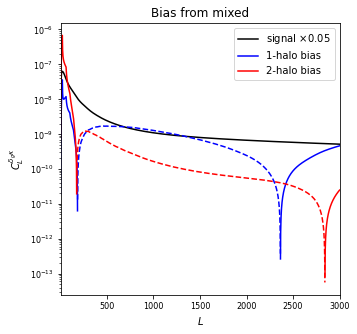

Text(0.5, 1.0, 'Bias from mixed')

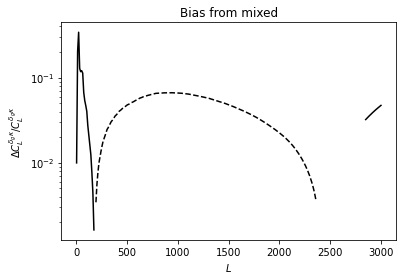

In [47]:
plt.figure(figsize=(5, 5))
scaling = 0.5 * experiment.biases['ells']*(experiment.biases['ells']+1)

plt.plot(ells, 0.05 * Cls, 'k', label=r'signal $\times 0.05$')

plt.plot(experiment.biases['ells'], scaling * cross_w_gals_1h_pos, color='b', label='1-halo bias')
plt.plot(experiment.biases['ells'], scaling * cross_w_gals_1h_neg, color='b', ls='--')

plt.plot(experiment.biases['ells'], scaling * cross_w_gals_2h_pos, color='r', label='2-halo bias')
plt.plot(experiment.biases['ells'], scaling * cross_w_gals_2h_neg, color='r', ls='--')

plt.yscale('log')
plt.xlim([2, 3000])
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.ylabel(r'$C_{L}^{\delta_{g}\kappa}$')
plt.xlabel(r'$L$')
plt.legend()
plt.title('Bias from {}'.format(which_bias))
plt.show()

plt.plot(ells, np.interp(ells, experiment.biases['ells'], scaling * (cross_w_gals_1h_pos + cross_w_gals_2h_pos)) / Cls, color='k')
plt.plot(ells, np.interp(ells, experiment.biases['ells'], scaling * (cross_w_gals_1h_neg + cross_w_gals_2h_neg)) / Cls, color='k', ls='--')
plt.yscale('log')
plt.ylabel(r'$\Delta C_{L}^{\delta_{g}\kappa} / C_{L}^{\delta_{g}\kappa}$')
plt.xlabel(r'$L$')
plt.title('Bias from {}'.format(which_bias))

# Test the FFTlog implementation of the QE

In [44]:
from cosmoblender import qest

We now test the FFTlog implementation of the 1D TT QE against a brute-force calculation of the integrals

Generate a y profile

In [42]:
y = tls.pkToPell(hm_calc.hcos.comoving_radial_distance(hm_calc.hcos.zs[1]),hm_calc.hcos.ks,\
                 hm_calc.hcos.pk_profiles['y'][1,1]*(1-np.exp(-(hm_calc.hcos.ks/hm_calc.hcos.p['kstar_damping']))), ellmax=experiment.lmax)

Calculate the (unnormalised) lensing reconstruction by brute force (this can be very slow)

In [45]:
output_ells = np.linspace(20, 3000, 10)

unnorm_rec_bruteforce = qest.get_brute_force_unnorm_TT_qe(output_ells, y, experiment.cltt_tot, experiment.ls, experiment.cl_len.cltt, experiment.lmax)

KeyboardInterrupt: 

Now calculate it using FFTlog

In [101]:
output_ells_refined =  np.arange(3000)

# FFTlog parameters
N_l= 2*4096#2*4096
lmin= .000135 #0.000135
alpha= -1.35#-1.35

unnorm_rec_fftlog = qest.get_TT_QE(True, output_ells_refined, y, experiment.qe_norm, experiment.pix,
                                   experiment.lmax, experiment.cltt_tot, experiment.ls, experiment.cl_len.cltt,
                                   N_l=N_l, lmin=lmin, alpha=alpha)

Compare the two

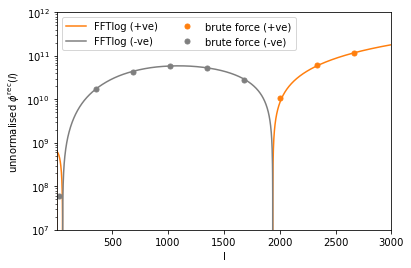

In [102]:
plt.semilogy(output_ells_refined, unnorm_rec_fftlog, color='tab:orange', label='FFTlog (+ve)')
plt.semilogy(output_ells_refined, - unnorm_rec_fftlog, color='tab:gray', label='FFTlog (-ve)')

plt.semilogy(output_ells, unnorm_rec_bruteforce, marker='o', lw=0, markersize=5, color='tab:orange', label='brute force (+ve)')
plt.semilogy(output_ells, -unnorm_rec_bruteforce, marker='o', markersize=5, lw=0, color='tab:gray', label='brute force (-ve)')

plt.xlim([1, 3000])
plt.ylim([1e7, 1e12])
plt.xlabel('l')
plt.ylabel(r'unnormalised $\phi^{\mathrm{rec}} (l)$')
plt.legend(loc='upper left', ncol=2)


# Calculate the biases to B-mode delensing

In [170]:
SO_5e15 = qest.experiment(6., 1.5, 3000, massCut_Mvir=5e15, freq_GHz=freq_GHz)
SO_1e15 = qest.experiment(6., 1.5, 3000, massCut_Mvir=1e15, freq_GHz=freq_GHz)
SO_5e14 = qest.experiment(6., 1.5, 3000, massCut_Mvir=5e14, freq_GHz=freq_GHz)

(-1e-07, 1.5e-07)

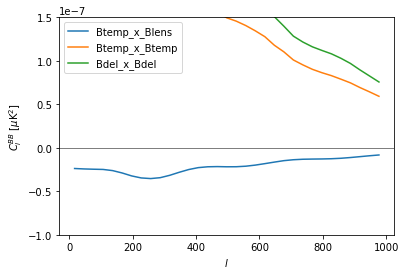

In [171]:
ells, cl_Btemp_x_Blens_bias, cl_Btemp_x_Btemp_bias, cl_Bdel_x_Bdel_bias = hm_calc.get_bias_to_delensed_clbb(SO_5e15)

plt.plot(ells, cl_Btemp_x_Blens_bias, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])

(-1e-07, 1.5e-07)

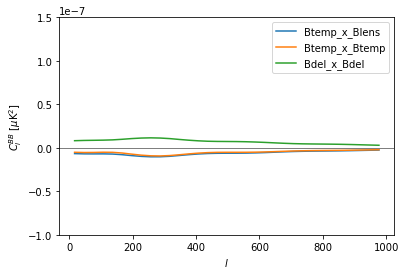

In [172]:
ells, cl_Btemp_x_Blens_bias_SO_1e15, cl_Btemp_x_Btemp_bias_SO_1e15, cl_Bdel_x_Bdel_bias_SO_1e15 = hm_calc.get_bias_to_delensed_clbb(SO_5e14)

plt.plot(ells, cl_Btemp_x_Blens_bias_SO_1e15, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias_SO_1e15, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias_SO_1e15, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])

(-1e-07, 1.5e-07)

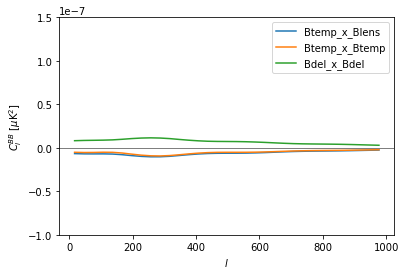

In [173]:
ells, cl_Btemp_x_Blens_bias_SO_5e14, cl_Btemp_x_Btemp_bias_SO_5e14, cl_Bdel_x_Bdel_bias_SO_5e14 = hm_calc.get_bias_to_delensed_clbb(SO_5e14)

plt.plot(ells, cl_Btemp_x_Blens_bias_SO_5e14, label=r'Btemp_x_Blens')
plt.plot(ells, cl_Btemp_x_Btemp_bias_SO_5e14, label=r'Btemp_x_Btemp')
plt.plot(ells, cl_Bdel_x_Bdel_bias_SO_5e14, label=r'Bdel_x_Bdel')
plt.ylabel(r'$C_l^{BB}$ [$\mu$K$^2$]')
plt.xlabel(r'$l$')
plt.legend()
plt.axhline(0, color='k', lw=0.5)
plt.ylim([-1e-7,1.5e-7])